### 基础模块导入

In [1]:
import torch
import numpy as np
from scipy.linalg import hadamard
import matplotlib.pyplot as plt
from quantize.hadmard import random_hadamard_matrix
import torch.nn.functional as F
import torch
import seaborn as sns
torch.cuda.set_device(5)
print(torch.cuda.current_device())  # 打印当前使用的 GPU 设备编号
print(torch.cuda.get_device_name(7))  # 打印设备 7 的名称

5
NVIDIA A800-SXM4-80GB


In [14]:
def plot_quantile_fig(data_,path,axis=-1):
    '''
    axis:需要查看的数据维度，保留的数据维度
    '''
    # width = 1
    torch.cuda.empty_cache()
    height = len(data_)
    fig,axes = plt.subplots(1,1)
    torch.cuda.synchronize(),torch.cuda.empty_cache()

    if isinstance(data_,torch.Tensor):
        if data_.requires_grad:
            data = data_.detach().cpu().numpy()
        else:
            data = data_.cpu().numpy()
    shape = data.shape
    if axis >= len(shape):
        raise ValueError("Axis should be less than data.shape")
    permuted_data = np.moveaxis(data, axis, 0)
    reshaped_data = permuted_data.reshape(shape[axis], -1).transpose(1,0)
    reshaped_data = torch.from_numpy(reshaped_data).cpu().float()
    pmax = torch.amax(reshaped_data,dim=0).cpu().numpy()
    p9999 = torch.quantile(reshaped_data,0.9999,dim=0).cpu().numpy()
    p99 = torch.quantile(reshaped_data,0.99,dim=0).cpu().numpy()
    p75 = torch.quantile(reshaped_data,0.75,dim=0).cpu().numpy()
    p25 = torch.quantile(reshaped_data,0.25,dim=0).cpu().numpy()
    p01 = torch.quantile(reshaped_data,0.01,dim=0).cpu().numpy()
    p0001 = torch.quantile(reshaped_data,0.0001,dim=0).cpu().numpy()
    pmin = torch.amin(reshaped_data,dim=0).cpu().numpy()
    x_label_ids = np.arange(len(pmin))
    del reshaped_data
    torch.cuda.synchronize(),torch.cuda.empty_cache()
    axes.plot(x_label_ids,p9999,color='red',label='1/9999 Percentile',linewidth=0.5)
    axes.plot(x_label_ids,p99,color='purple',label='1/99 Percentile',linewidth=0.5)
    axes.plot(x_label_ids,p75,color='orange',label='25/75 Percentile',linewidth=0.5)
    axes.plot(x_label_ids,p25,color='orange',linewidth=0.5)
    axes.plot(x_label_ids,p01,color='purple',linewidth=0.5)
    axes.plot(x_label_ids,p0001,color='red',linewidth=0.5)
    axes.plot(x_label_ids,pmax,color='blue',linewidth=0.5)
    axes.plot(x_label_ids,pmin,color='blue',label='Min/Max',linewidth=0.5)
    
    

    axes.set_xlabel('Hidden dimension index')
    axes.set_ylabel('Activation value')
    axes.legend(loc='upper right')
    # plt.title(path)
    fig.tight_layout(rect=[0,0.05,1,0.95])
    plt.show()

def plot_quantile_fig_2(data_,path,axis=-1):
    '''
    axis:需要查看的数据维度，保留的数据维度
    '''
    # width = 1
    torch.cuda.empty_cache()
    height = len(data_)
    fig, axes = plt.subplots(figsize=(12,6))
    torch.cuda.synchronize(),torch.cuda.empty_cache()

    if isinstance(data_,torch.Tensor):
        if data_.requires_grad:
            data = data_.detach().cpu().numpy()
        else:
            data = data_.cpu().numpy()
    shape = data.shape
    if axis >= len(shape):
        raise ValueError("Axis should be less than data.shape")
    permuted_data = np.moveaxis(data, axis, 0)
    reshaped_data = permuted_data.reshape(shape[axis], -1).transpose(1,0)
    reshaped_data = torch.from_numpy(reshaped_data).cpu().float()
    pmax = torch.amax(reshaped_data,dim=0).cpu().numpy()
    # p9999 = torch.quantile(reshaped_data,0.9999,dim=0).cpu().numpy()
    p99 = torch.quantile(reshaped_data,0.99,dim=0).cpu().numpy()
    p75 = torch.quantile(reshaped_data,0.75,dim=0).cpu().numpy()
    p25 = torch.quantile(reshaped_data,0.25,dim=0).cpu().numpy()
    p01 = torch.quantile(reshaped_data,0.01,dim=0).cpu().numpy()
    # p0001 = torch.quantile(reshaped_data,0.0001,dim=0).cpu().numpy()
    pmin = torch.amin(reshaped_data,dim=0).cpu().numpy()
    x_label_ids = np.arange(len(pmin))
    del reshaped_data
    torch.cuda.synchronize(),torch.cuda.empty_cache()
    sns.set(style="white")
    color_minmax = "#1f77b4"#"blue"#"#1f77b4"  # 蓝色
    color_percentile_199 = "red"#d62728#"magenta"#"#d62728"  # 红色
    color_percentile_2575 = "orange"#"#FF5733"#"#ff7f0e"  # 黄色

    # axes.plot(x_label_ids,p9999,color='purple',label='1/9999 Percentile',linewidth=0.5)
    axes.plot(x_label_ids,p99,color=color_percentile_199,label='1/99 Percentile',linewidth=0.5,alpha=0.8)
    axes.plot(x_label_ids,p75,color=color_percentile_2575,label='25/75 Percentile',linewidth=0.5,alpha=0.5)
    axes.plot(x_label_ids,p25,color=color_percentile_2575,linewidth=0.5,alpha=0.5)
    axes.plot(x_label_ids,p01,color=color_percentile_199,linewidth=0.5,alpha=0.8)
    # axes.plot(x_label_ids,p0001,color='purple',linewidth=0.5)
    axes.plot(x_label_ids,pmax,color=color_minmax,linewidth=0.5,alpha=1)
    axes.plot(x_label_ids,pmin,color=color_minmax,label='Min/Max',linewidth=0.5,alpha=1)

    axes.set_ylim([-0.13, 0.13])
    
    axes.set_xlabel('Hidden dimension index')
    axes.set_ylabel('Value')
    axes.legend(loc='upper right')
    # plt.title(path)
    fig.tight_layout(rect=[0,0.05,1,0.95])
    # fig.savefig(path,dpi=300)
    # print("saveing: ",path)
    # plt.close()
    plt.show()
    
def plot_bar_fig_ori(data_,path,loss):
    if isinstance(data_,torch.Tensor):
        if data_.requires_grad:
            data = data_.detach().cpu().numpy()
        else:
            data = data_.cpu().numpy()
    min_=np.min(data)
    max_=np.max(data)
    data_range = max_ - min_
    bin_width = data_range / 100  # 设定每个区间的宽度
    bins = np.arange(min_, max_ + bin_width, bin_width)
    # bins = np.arange(-0.6, 0.6, 0.01)
    # bins = np.arange(-0.02, 0.02, 0.0005)
    plt.hist(data.reshape(-1), bins=bins, edgecolor='black')
    # plt.xlim(-0.015, 0.015)  # 限制横坐标范围
    # plt.xlim(-0.02, 0.02)  # 限制横坐标范围
    
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
    
    plt.text(0.95, 0.95, f'mean abs loss: {loss:.4f}', horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)
    
    # plt.title(path)
    plt.xlabel("loss val")
    plt.ylabel("num")
    try:
        plt.tight_layout()
    except Exception as e:
        print(f"Warning: tight_layout failed with error: {e}") #用于自动调整子图参数，使图形中的子图、标签、标题等不重叠，并且整体布局更加紧凑美观
    plt.show()
    plt.close()

def plot_bar_fig(data1, path, loss):
    # 将 data1 转换为 numpy 数组
    if isinstance(data1, torch.Tensor):
        if data1.requires_grad:
            data1 = data1.detach().cpu().numpy()
        else:
            data1 = data1.cpu().numpy()

    # 计算 data1 的直方图
    min_ = np.min(data1)
    max_ = np.max(data1)
    data_range = max_ - min_
    bin_width = data_range / 100  # 设定每个区间的宽度
    bins = np.arange(min_, max_ + bin_width, bin_width)
    plt.figure(figsize=(12, 6))
    # 绘制 data1 的直方图
    counts1, bin_edges1, _ = plt.hist(data1.reshape(-1), bins=bins, edgecolor='black', label=path)


    # 获取柱子的中心位置
    bin_centers = (bin_edges1[:-1] + bin_edges1[1:]) / 2
    # 设置横纵坐标范围
    # plt.xlim(min_, max_)  # 根据 data1 的范围设置横坐标范围
    plt.xlim(-0.015, 0.015)  # 限制横坐标范围
    plt.ylim(0, 200000)  # 限制横坐标范围
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1)

    # 添加文字注释
    plt.text(0.95, 0.95, f'L1 loss: {loss:.4f}', horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)

    # 设置图例和标签
    plt.xlabel("Loss Value")
    plt.ylabel("Count")
    plt.legend()

    # 自动调整布局
    try:
        plt.tight_layout()
    except Exception as e:
        print(f"Warning: tight_layout failed with error: {e}")

    # 显示图表
    plt.show()

def plot_bar3d_fig(data_,path,axis=-1):
    '''
    data_:消除了batch维度的数据,在最后一维度上展开数据
    
    '''
    plt.ioff()
    if isinstance(data_,torch.Tensor):
        data_ = data_.reshape(data_.shape[0],-1).abs()
        if data_.requires_grad:
            data = data_.detach().cpu().numpy()
        else:
            data = data_.cpu().numpy()
    else:
        data = data_
        
    # shape = data.shape
    # if axis >= len(shape):
    #     raise ValueError("Axis should be less than data.shape")
    # permuted_data = np.moveaxis(data, axis, 0)
    # reshaped_data = permuted_data.reshape(shape[axis], -1)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # 获取数据的维度
    x_len, y_len = data.shape

    # 生成X和Y的坐标
    _x = np.arange(x_len)
    _y = np.arange(y_len)
    
    # meshgrid的参数顺序应该与数据存储的顺序一致：行 -> x轴, 列 -> y轴
    _xx, _yy = np.meshgrid(_x, _y, indexing="ij")
    x, y = _xx.ravel(), _yy.ravel()

    # 数据展开为一维
    top = data.ravel()
    bottom = np.zeros_like(top)
    
    # 调整宽度和深度
    width = depth = 0.3

    # 使用颜色映射工具
    cmap = plt.cm.viridis  # 可以选择其他合适的颜色映射
    
    # 颜色映射的归一化比例
    # colors = cmap(1 - (top / float(top.max()))) #反转颜色条
    colors = cmap(top / float(top.max()))

    # 绘制3D柱状图
    ax.bar3d(x, y, bottom, width, depth, top, shade=True, color=colors)

    # 设置轴标签和标题
    plt.title(path)
    ax.set_xlabel("token")
    ax.set_ylabel("hidden dim")
    # ax.set_zlabel("value")
    
    # 颜色条
    # mappable = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=top.min(), vmax=top.max())) #反转颜色条设置 vmin 为 top.max(), vmax 为 top.min()
    mappable = plt.cm.ScalarMappable(cmap='viridis')
    mappable.set_array(top)
    fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=5, label="Value")
    
    # 调整视角
    ax.view_init(elev=30, azim=45)

    try:
        plt.tight_layout()
    except Exception as e:
        print(f"Warning: tight_layout failed with error: {e}")
        
    # 保存图像
    plt.show()

def quantize(tensor, num_bits):
    # 计算量化级数
    qmin = 0
    qmax = 2 ** num_bits - 1

    # 找到张量的最小值和最大值
    min_val, max_val = tensor.min(), tensor.max()

    # 量化比例因子
    scale = (max_val - min_val) / (qmax - qmin)
    zero_point = qmin - min_val / scale

    # 量化
    quantized = (tensor / scale + zero_point).round().clamp(qmin, qmax)

    return quantized, scale, zero_point

def dequantize(quantized, scale, zero_point):
    # 反量化
    return scale * (quantized - zero_point)

def resize_tensor(tensor, size=(500, 500)):
    """
    将二维 tensor 重新采样到指定大小。

    Args:
        tensor: 输入的二维 tensor。
        size: 输出的大小，默认为 (500, 500)。

    Returns:
        重新采样后的 tensor。
    """
    h, w = tensor.shape
    target_h, target_w = size

    # 如果某个维度小于目标大小，不进行降采样
    new_h = min(h, target_h)
    new_w = min(w, target_w)
    
    # 调整到新尺寸
    resized_tensor = F.interpolate(tensor.unsqueeze(0).unsqueeze(0), size=(new_h, new_w), mode='bilinear')#nearest,bilinear
    
    # 将 tensor 的维度恢复
    return resized_tensor.squeeze(0).squeeze(0)

def plot_line_fig(data, path):
    # 确保数据可以转换为一维数组
    if isinstance(data, torch.Tensor):
        if data.requires_grad:
            data = data.detach().cpu().numpy()[:,:500]
        else:
            data = data.cpu().numpy()
    max = np.amax(data, axis=0)
    max = np.array(max).flatten()
    
    var = np.var(data, axis=0)
    var = np.array(var).flatten()*500
    
    plt.figure(figsize=(12,6))
    
    # 绘制折线图
    plt.plot(max, color='blue', label='max',linewidth=1)
    plt.plot(var, color='red', label='var*500',linewidth=1) 
    
    # 设置图表标题和坐标轴标签
    # plt.title(path)
    plt.xlabel("Hidden dimension index",fontsize=28)
    plt.ylabel("Value",fontsize=28)
    
    # 设置刻度值大小
    plt.tick_params(axis='both', labelsize=20) 
    
    plt.xlim()
    plt.ylim([0,0.14])
    plt.legend(loc='upper right',fontsize=30)
    
    try:
        plt.tight_layout()  # 自动调整布局
    except Exception as e:
        print(f"Warning: tight_layout failed with error: {e}")
    
    # 保存图表
    plt.show()
    # plt.savefig(path)
    plt.close()
    # print('saving:  ', path)

def plot_line_fig(data, path):
    # 确保数据可以转换为一维数组
    if isinstance(data, torch.Tensor):
        if data.requires_grad:
            data = data.detach().cpu().numpy()[:,:500]
        else:
            data = data.cpu().numpy()
    
    # 计算最大值和方差
    max_values = np.amax(data, axis=0).flatten()
    var_values = np.var(data, axis=0).flatten() * 500
    
    # 创建图形和轴
    fig, ax1 = plt.subplots(figsize=(12,6))
    
    # 绘制 max 的折线图 (左 y 轴)
    color_max = 'tab:blue'
    ax1.set_xlabel("Hidden dimension index", fontsize=28)
    ax1.set_ylabel("Max Value", fontsize=28)
    ax1.plot(max_values, color=color_max, label='max', linewidth=1)
    ax1.tick_params(axis='y', labelcolor=color_max, labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax1.set_ylim([0, 0.12])
    
    # 创建第二个 y 轴，并绘制方差 var 的折线图 (右 y 轴)
    ax2 = ax1.twinx()
    color_var = 'tab:red'
    ax2.set_ylabel("Variance", fontsize=28)
    ax2.plot(var_values, color=color_var, label='var', linewidth=1)
    ax2.tick_params(axis='y', labelcolor=color_var, labelsize=20)
    ax2.set_ylim([0.01, 0.05])
    
    # 设置图例
    ax1.legend(loc='upper left', fontsize=20)
    ax2.legend(loc='upper right', fontsize=20)
    
    # 自动调整布局
    try:
        plt.tight_layout()
    except Exception as e:
        print(f"Warning: tight_layout failed with error: {e}")
    
    # 显示图表
    plt.show()
    
    # 保存图表
    # plt.savefig(path)
    plt.close()
  
    

    

### 绘制dt_proj图

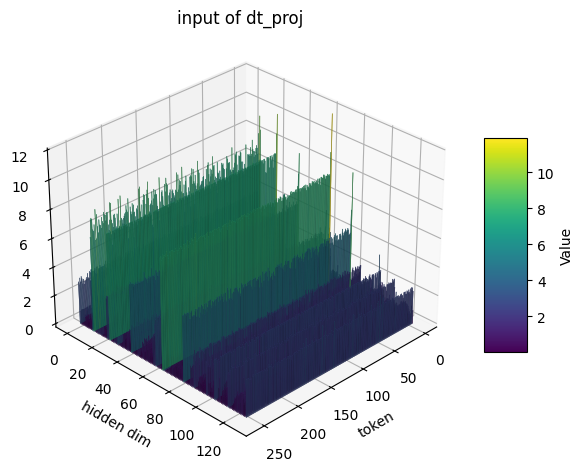

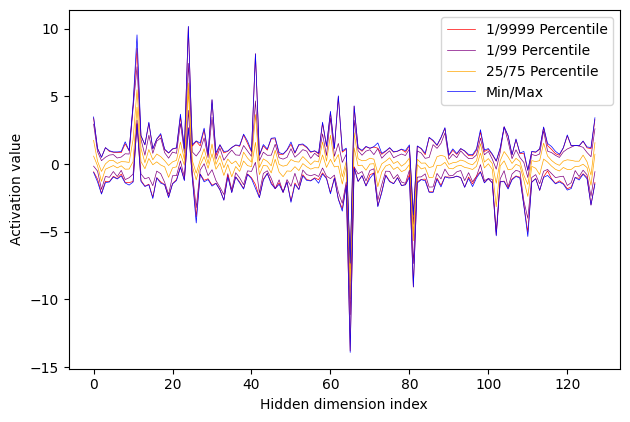

In [21]:
time_step = torch.load("/data01/home/xuzk/workspace/mamba_quant_comp/model_vim_quant/data/tmp_data/mamba-1.4b_dt_proj_input_data_1.pt")
b,l,d = time_step.shape
plot_bar3d_fig(resize_tensor(torch.amax(time_step,dim=0),size=(l,300)), f"input of dt_proj", axis=-1)
plot_quantile_fig(time_step,f"input of dt_proj",axis=-1)

### 绘制matmul的bar3d图

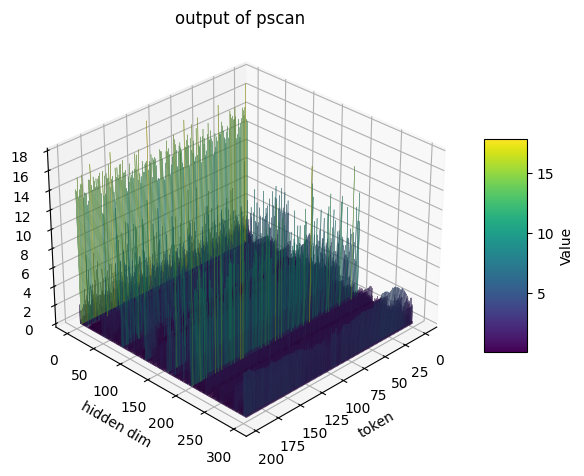

In [6]:
hs = torch.load("/data01/home/xuzk/workspace/mamba_quant_comp/model_vim_quant/data/tmp_data/vim_tiny_matmul_data_2.pt")
b,l,n,d = hs.shape
plot_bar3d_fig(resize_tensor(torch.amax(hs.reshape(b,l,n*d),dim=0),size=(197,300)), f"output of pscan", axis=-1)
# plot_bar3d_fig(torch.amax(hs.reshape(b,l,n*d),dim=0), f"output of pscan", axis=-1)

### 随机数据验证均值不为0的旋转效果

In [147]:
data_ = torch.randn(500,384)
random_indices = torch.randperm(data_.size(-1))[:100]
scales = torch.empty(100).uniform_(0.3, 2.0)
for i, index in enumerate(random_indices):
    data_[:,index] *= scales[i]
    # data_[:,index] = data_[:,index] + scales[i] if i%2==0 else data_[:,index] - scales[i]
cov_matrix = torch.cov(data_.reshape(-1,384).double().T)
eig_values, K_ = torch.linalg.eig(cov_matrix.double())
eig_values_, eig_vectors = torch.linalg.eigh(cov_matrix.double())
from quantize.hadmard import random_hadamard_matrix
R = random_hadamard_matrix(a.shape[1],a.device).cuda()

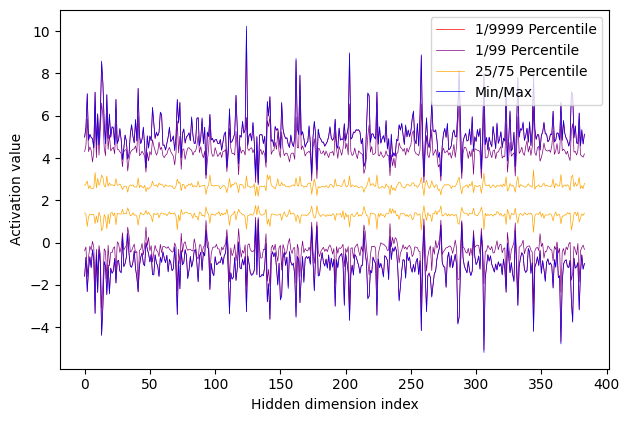

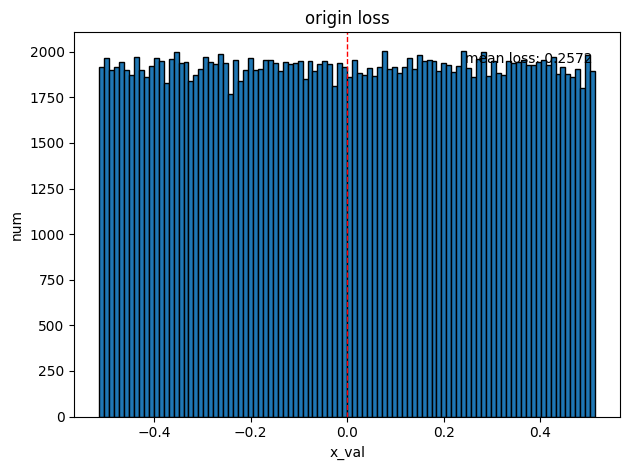

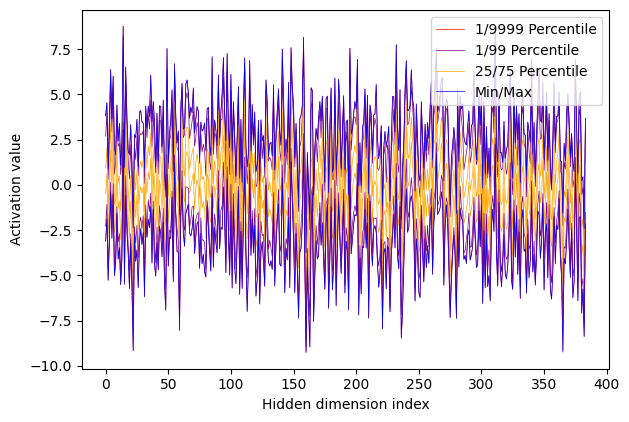

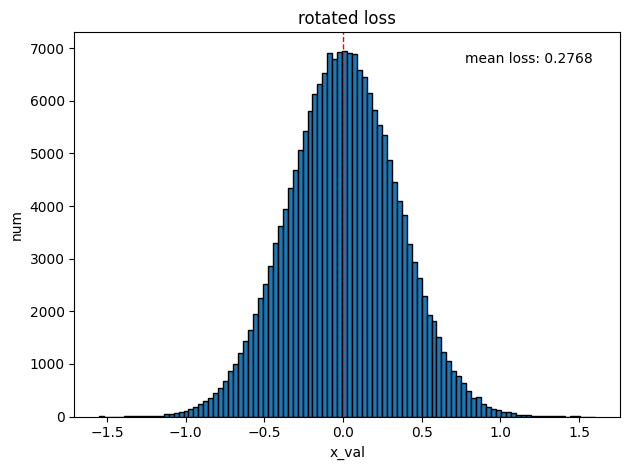

In [163]:
a = (data_+2).cuda().float()
plot_quantile_fig(a,"",axis=-1)
loss1 = a-dequantize(*quantize(a, 4))
plot_bar_fig(loss1,"origin loss",loss1.abs().mean())
plot_quantile_fig(a@R.cuda().float(),"",axis=-1)
loss2 = a-dequantize(*quantize(a@R.cuda().float(), 4))@R.T.cuda().float()
plot_bar_fig(loss2,"rotated loss",loss2.abs().mean())


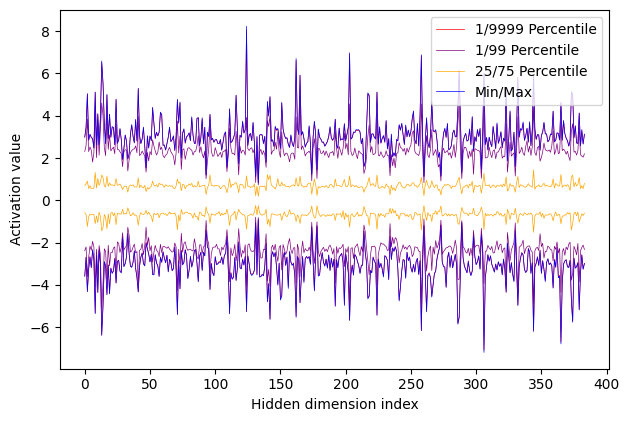

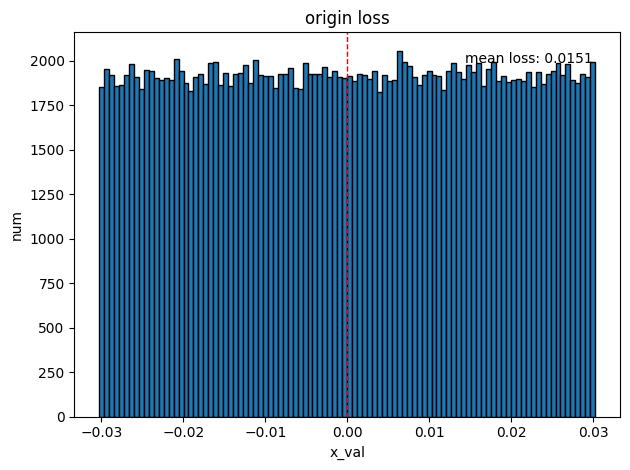

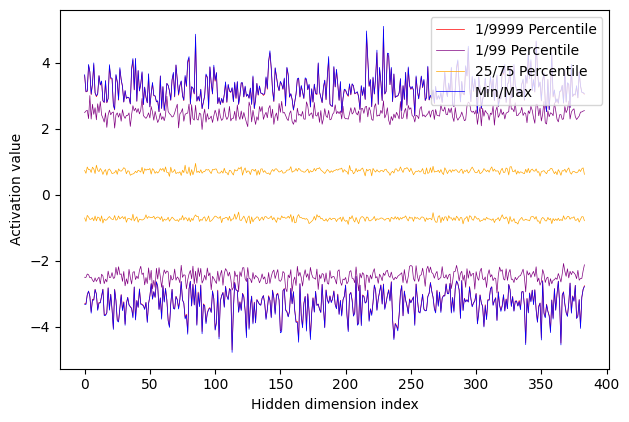

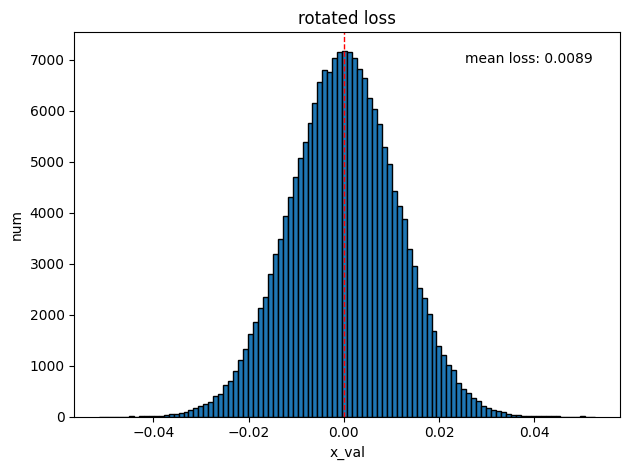

In [162]:
a = data_.cuda().float()
plot_quantile_fig(a,"a.jpg",axis=-1)
loss1 = a-dequantize(*quantize(a, 8))
plot_bar_fig(loss1,"origin loss",loss1.abs().mean())
plot_quantile_fig(a.cuda().float()@R.cuda().float(),"data/ori_K_T.jpg",axis=-1)
loss2 = a-dequantize(*quantize(a@R.cuda().float(), 8))@R.T.cuda().float()
plot_bar_fig(loss2,"rotated loss",loss2.abs().mean())

### 激活klt最好的示例

In [45]:
from quantize.hadmard import random_hadamard_matrix
R = random_hadamard_matrix(384,data_.device)

In [57]:

import fast_hadamard_transform
FR = fast_hadamard_transform.hadamard_transform(data_.cuda().contiguous(), 1.0/torch.tensor(384).sqrt()) 
FR

tensor([[ 0.4562,  0.3383,  0.9243,  ...,  0.1507,  0.3866,  0.4576],
        [-0.8117,  0.4516, -0.7651,  ...,  0.0474,  0.4024,  0.1112],
        [-1.1257,  1.1136,  0.4594,  ...,  0.0133, -0.1931, -0.4310],
        ...,
        [-2.5119, -0.1349,  1.0018,  ...,  2.4461,  0.0420, -0.4212],
        [ 0.3359,  0.2113, -0.0045,  ..., -1.3632,  0.6892,  0.6858],
        [ 0.0504, -1.1319, -1.8228,  ..., -0.3368, -0.7800,  0.9089]],
       device='cuda:0')

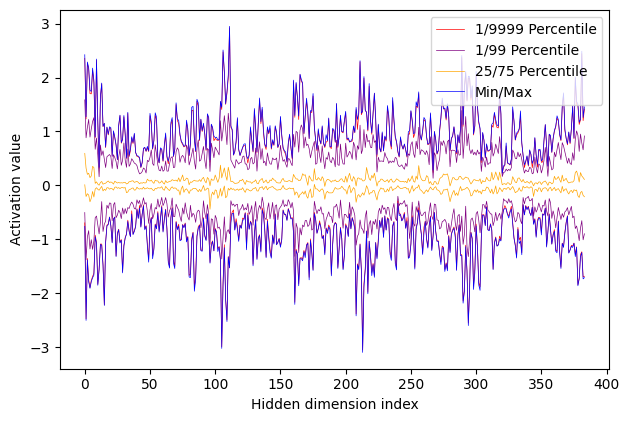

In [65]:
act  = torch.load("/data01/home/xuzk/workspace/mamba_quant_comp_copy/model_vim_quant/data/m.pt")
a = act
#a = a.cuda().float()@ K_.cuda().float()
import fast_hadamard_transform
b=fast_hadamard_transform.hadamard_transform(a.cuda().contiguous(), 1.0/torch.tensor(384).sqrt())
plot_quantile_fig(b,"data/ori_K_T.jpg",axis=-1)

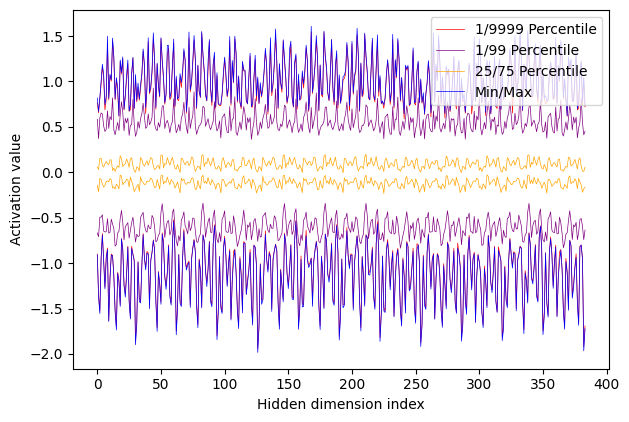

In [67]:
act  = torch.load("/data01/home/xuzk/workspace/mamba_quant_comp_copy/model_vim_quant/data/m.pt")
cov_matrix = torch.cov(act.reshape(-1,384).double().T)
eig_values, K_ = torch.linalg.eig(cov_matrix.double())
eig_values_, eig_vectors = torch.linalg.eigh(cov_matrix.double())
from quantize.hadmard import random_hadamard_matrix
R = random_hadamard_matrix(384,data_.device)
plot_quantile_fig(act.float()@K_.cuda().float()@R.cuda().float(),"data/ori_K_T.jpg",axis=-1)

### 激活示例

In [27]:
# data = torch.load("/data01/home/xuzk/workspace/mamba_quant_comp/model_vim_quant/data/tmp_data/origin_qproj.pth")
data = torch.load("/data01/home/xuzk/workspace/mamba_quant_comp/model_vim_quant/data/tmp_data/m.pt")
data = data.reshape(-1,data.shape[-1])
from quantize.hadmard import random_hadamard_matrix
# R = random_hadamard_matrix(data.shape[-1],data.device)
R = torch.load('/data01/home/xuzk/workspace/mamba_quant_comp/model_vim_quant/data/tmp_data/hadamard_matric.pt')
cov_matrix = torch.cov(data.double().T)
eig_values_, K = torch.linalg.eigh(cov_matrix.double())

weight = torch.load("/data01/home/xuzk/workspace/mamba_quant_comp/model_vim_quant/data/tmp_data/origin_qproj.pth")
weight = F.interpolate(weight.unsqueeze(0).unsqueeze(0), size=(31520, 384), mode='nearest').squeeze(0).squeeze(0)

In [3]:
alpha = 0.5
act = torch.max(data,dim=0)[0].clip(min=0.1)
weight_scales = torch.max(weight,dim=0)[0].clip(min=0.1)
smooth = (act.pow(alpha) / weight_scales.pow(1 - alpha)).clamp(min=1e-2)
smooth.shape
var_values = torch.var(data, dim=0).flatten()

In [58]:
torch.min(smooth)

tensor(0.9998, device='cuda:0')

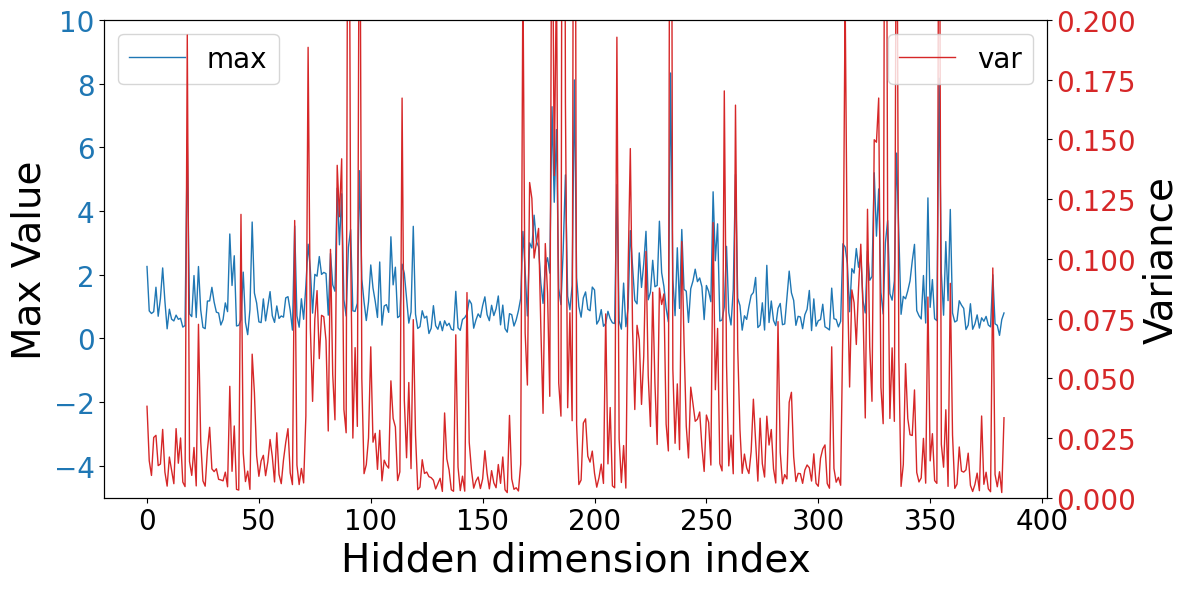

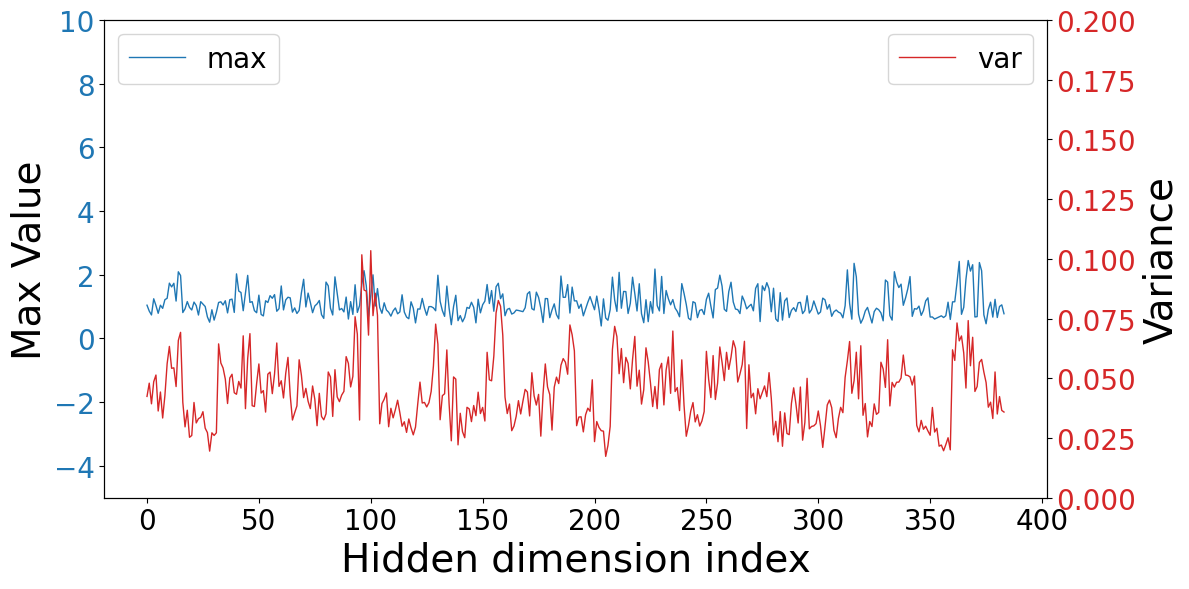

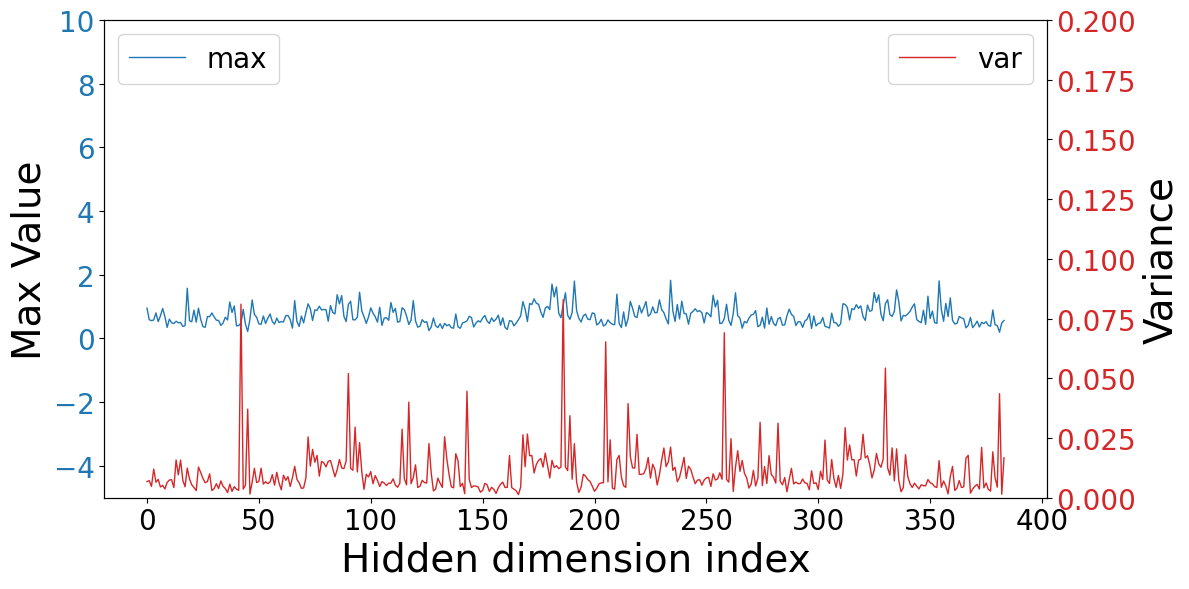

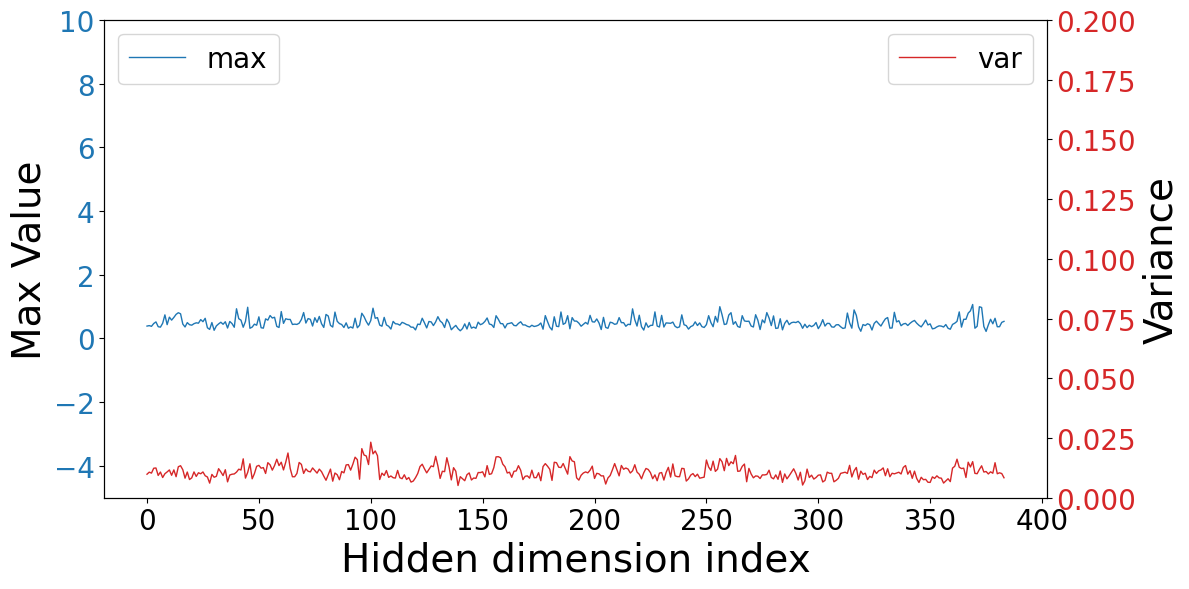

In [6]:
def plot_line_fig(data, path):
    # 确保数据可以转换为一维数组
    if isinstance(data, torch.Tensor):
        if data.requires_grad:
            data = data.detach().cpu().numpy()[:,:500]
        else:
            data = data.cpu().numpy()
    
    # 计算最大值和方差
    max_values = np.amax(data, axis=0).flatten()
    var_values = np.var(data, axis=0).flatten()
    
    # 创建图形和轴
    fig, ax1 = plt.subplots(figsize=(12,6))
    
    # 绘制 max 的折线图 (左 y 轴)
    color_max = 'tab:blue'
    ax1.set_xlabel("Hidden dimension index", fontsize=28)
    ax1.set_ylabel("Max Value", fontsize=28)
    ax1.plot(max_values, color=color_max, label='max', linewidth=1)
    ax1.tick_params(axis='y', labelcolor=color_max, labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    ax1.set_ylim([-5, 10])
    
    # 创建第二个 y 轴，并绘制方差 var 的折线图 (右 y 轴)
    ax2 = ax1.twinx()
    color_var = 'tab:red'
    ax2.set_ylabel("Variance", fontsize=28)
    ax2.plot(var_values, color=color_var, label='var', linewidth=1)
    ax2.tick_params(axis='y', labelcolor=color_var, labelsize=20)
    ax2.set_ylim([0, 0.2])
    
    # 设置图例
    ax1.legend(loc='upper left', fontsize=20)
    ax2.legend(loc='upper right', fontsize=20)
    
    # 自动调整布局
    try:
        plt.tight_layout()
    except Exception as e:
        print(f"Warning: tight_layout failed with error: {e}")
    
    # 显示图表
    plt.show()
    
    # 保存图表
    # plt.savefig(path)
    plt.close()
plot_line_fig(data.float(),"origin data")
plot_line_fig(data.float()@R.float(),"origin data")
plot_line_fig((data.float()/(smooth*0.5)),"origin data")
plot_line_fig((data.float()/(smooth*0.5))@R.float(),"origin data")
# plot_line_fig(data.float()@K.float()@R.float(),"origin data")

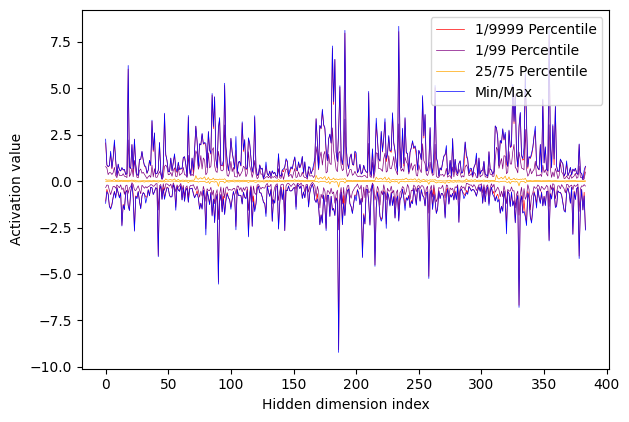

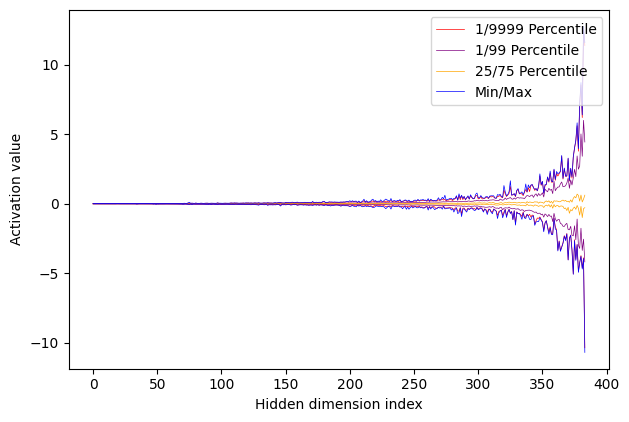

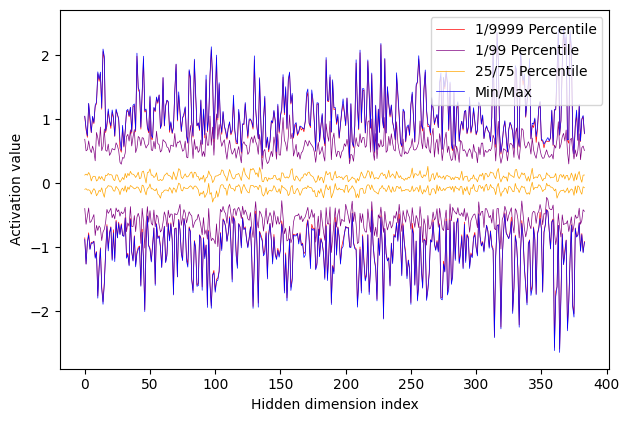

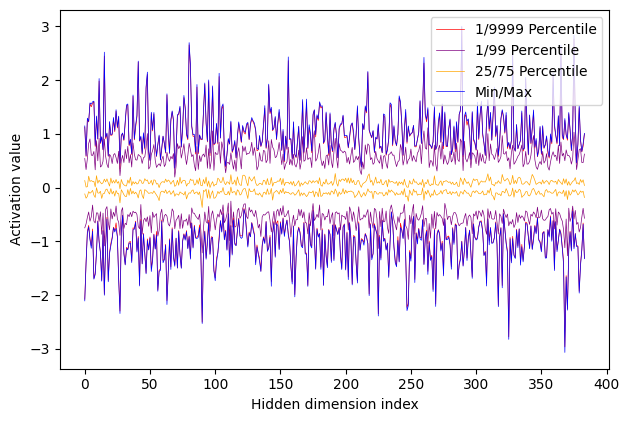

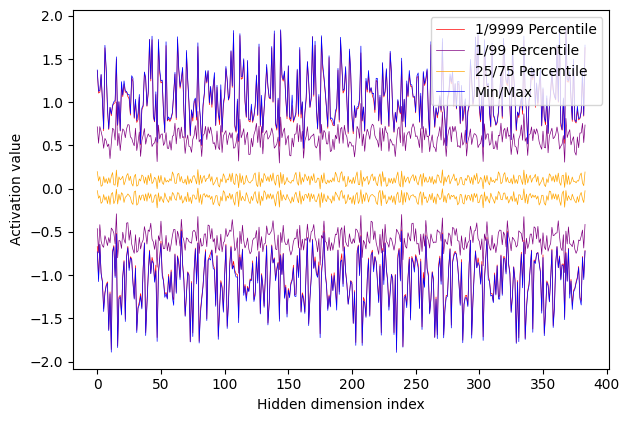

In [7]:
plot_quantile_fig(data,"data/ori_K_T.jpg",axis=1)
plot_quantile_fig(data.float()@K.float(),"data/ori_K_T.jpg",axis=1)
plot_quantile_fig(data.float()@R.float(),"data/ori_K_T.jpg",axis=1)
plot_quantile_fig(data.float()@R.float()@R.float(),"data/ori_K_T.jpg",axis=1)
plot_quantile_fig(data.float()@K.float()@R.float(),"data/ori_K_T.jpg",axis=1)

In [ ]:
loss1 = data-dequantize(*quantize(data, 4))
print(loss1.abs().mean())
plot_bar_fig(loss1.float(),"origin",loss1.abs().mean())
loss2 = data-dequantize(*quantize(data.float()@K.float(), 4))@K.T.float()
print(loss2.abs().mean())
plot_bar_fig(loss2.float(),"klt rotate",loss2.abs().mean())
loss3 = data-dequantize(*quantize(data.float()@R.float(), 4))@R.T.float()
print(loss3.abs().mean())
plot_bar_fig(loss3.float(),"hadamard rotate",loss3.abs().mean())
loss4 = data-dequantize(*quantize(data.float()@R.float()@R.float(), 4))@R.T.float()@R.T.float()
print(loss4.abs().mean())
plot_bar_fig(loss4.float(),"hadamard rotate twice",loss4.abs().mean())
loss5 = data-dequantize(*quantize(data.float()@K.float()@R.float(), 4))@R.T.float()@K.T.float()
print(loss5.abs().mean())
plot_bar_fig(loss5.float(),"klt rotate + hadamard rotate",loss5.abs().mean())

### 权重示例

In [30]:
data = torch.load("/data01/home/xuzk/workspace/mamba_quant_comp/model_vim_quant/data/tmp_data/origin_qproj.pth")
data = F.interpolate(data.unsqueeze(0).unsqueeze(0), scale_factor=(1, 0.25), mode='nearest')
data = data.squeeze(0).squeeze(0)
data = data.reshape(-1,data.shape[-1])
from quantize.hadmard import random_hadamard_matrix
R = random_hadamard_matrix(data.shape[-1],data.device)
cov_matrix = torch.cov(data.double().T)
eig_values_, K = torch.linalg.eigh(cov_matrix.double())

In [ ]:
plot_line_fig(data.float(),"origin data")
plot_line_fig(data.float()@R.float(),"origin data")
plot_line_fig(data.float()@K.float()@R.float(),"origin data")

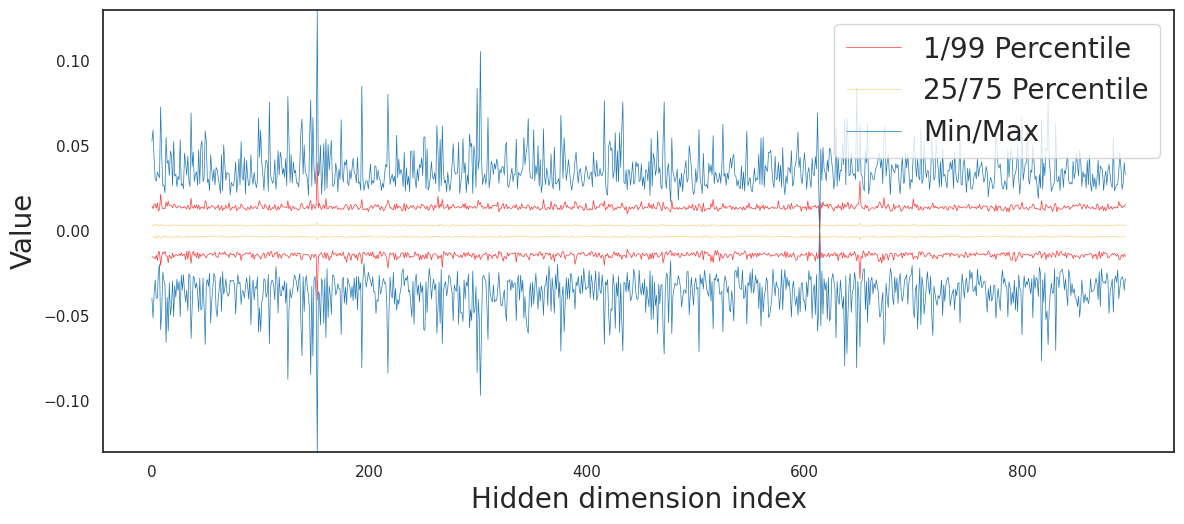

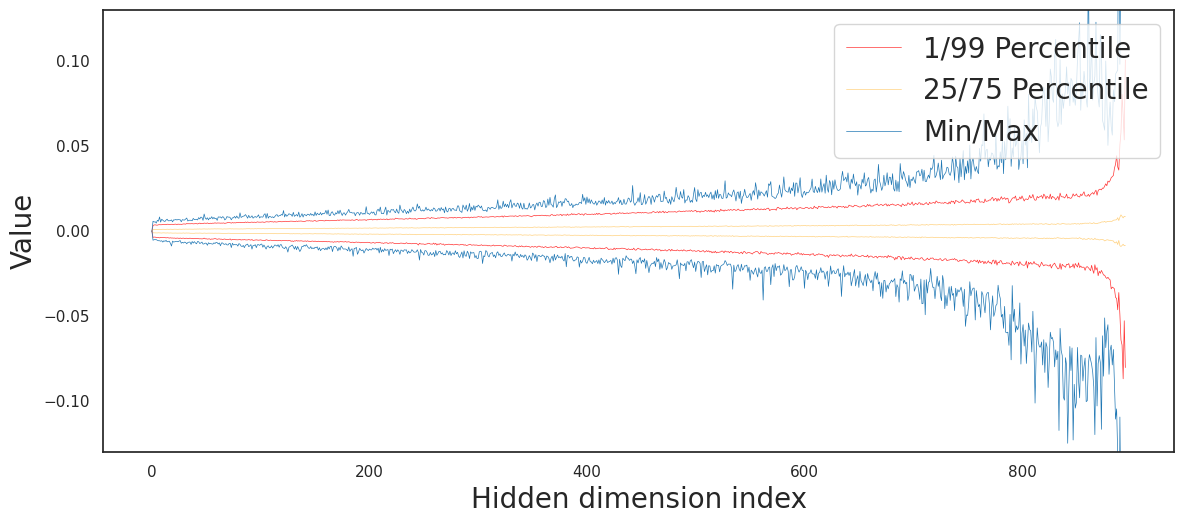

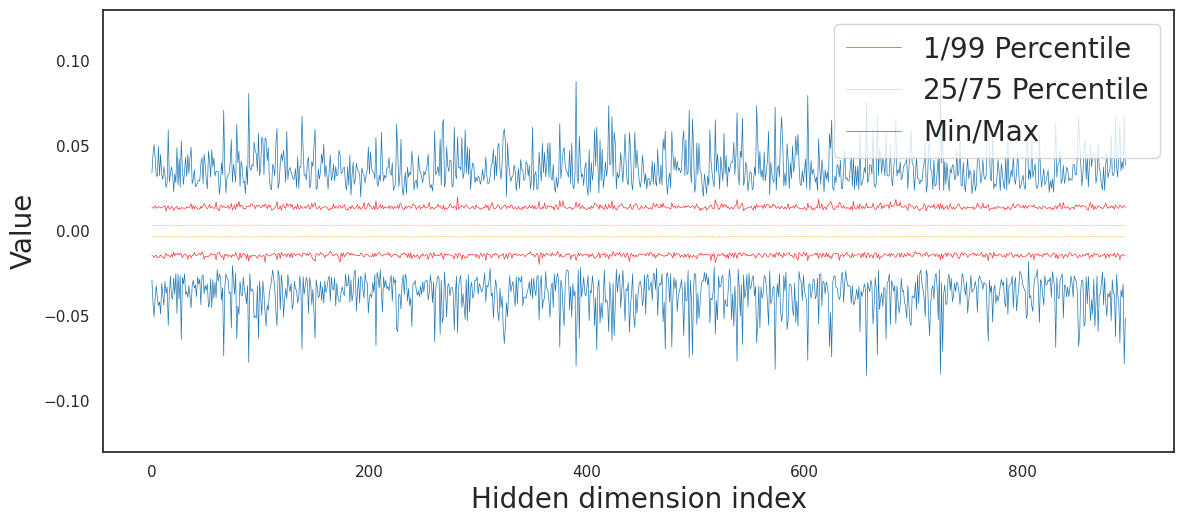

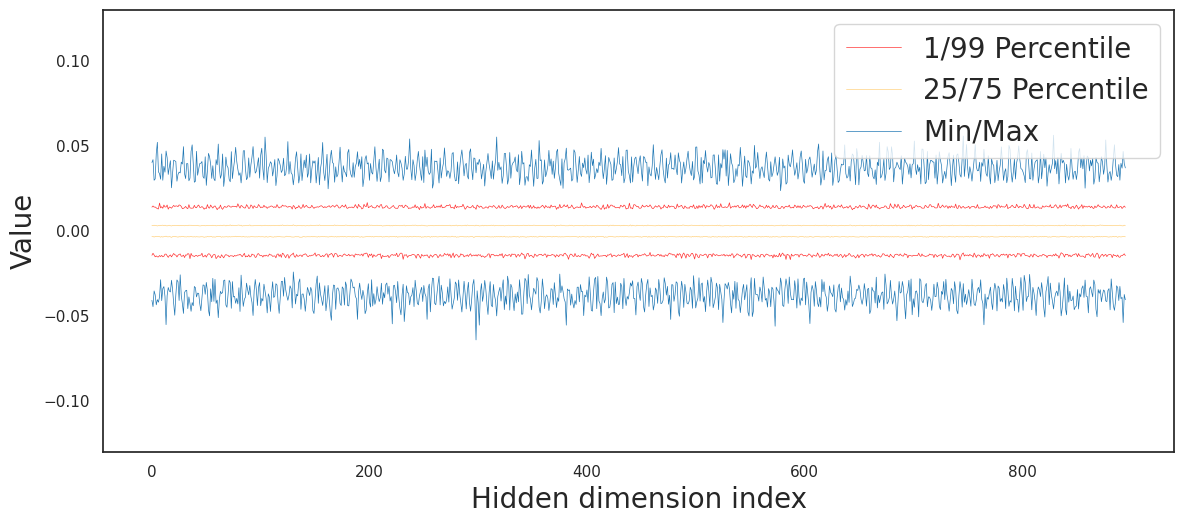

In [22]:
def plot_quantile_fig_2(data_,path,axis=-1):
    '''
    axis:需要查看的数据维度，保留的数据维度
    '''
    # width = 1
    torch.cuda.empty_cache()
    height = len(data_)
    fig, axes = plt.subplots(figsize=(12,6))
    torch.cuda.synchronize(),torch.cuda.empty_cache()

    if isinstance(data_,torch.Tensor):
        if data_.requires_grad:
            data = data_.detach().cpu().numpy()
        else:
            data = data_.cpu().numpy()
    shape = data.shape
    if axis >= len(shape):
        raise ValueError("Axis should be less than data.shape")
    permuted_data = np.moveaxis(data, axis, 0)
    reshaped_data = permuted_data.reshape(shape[axis], -1).transpose(1,0)
    reshaped_data = torch.from_numpy(reshaped_data).cpu().float()
    pmax = torch.amax(reshaped_data,dim=0).cpu().numpy()
    # p9999 = torch.quantile(reshaped_data,0.9999,dim=0).cpu().numpy()
    p99 = torch.quantile(reshaped_data,0.99,dim=0).cpu().numpy()
    p75 = torch.quantile(reshaped_data,0.75,dim=0).cpu().numpy()
    p25 = torch.quantile(reshaped_data,0.25,dim=0).cpu().numpy()
    p01 = torch.quantile(reshaped_data,0.01,dim=0).cpu().numpy()
    # p0001 = torch.quantile(reshaped_data,0.0001,dim=0).cpu().numpy()
    pmin = torch.amin(reshaped_data,dim=0).cpu().numpy()
    x_label_ids = np.arange(len(pmin))
    del reshaped_data
    torch.cuda.synchronize(),torch.cuda.empty_cache()
    sns.set(style="white")
    color_minmax = "#1f77b4"#"blue"#"#1f77b4"  # 蓝色
    color_percentile_199 = "red"#d62728#"magenta"#"#d62728"  # 红色
    color_percentile_2575 = "orange"#"#FF5733"#"#ff7f0e"  # 黄色

    # axes.plot(x_label_ids,p9999,color='purple',label='1/9999 Percentile',linewidth=0.5)
    axes.plot(x_label_ids,p99,color=color_percentile_199,label='1/99 Percentile',linewidth=0.5,alpha=0.8)
    axes.plot(x_label_ids,p75,color=color_percentile_2575,label='25/75 Percentile',linewidth=0.5,alpha=0.5)
    axes.plot(x_label_ids,p25,color=color_percentile_2575,linewidth=0.5,alpha=0.5)
    axes.plot(x_label_ids,p01,color=color_percentile_199,linewidth=0.5,alpha=0.8)
    # axes.plot(x_label_ids,p0001,color='purple',linewidth=0.5)
    axes.plot(x_label_ids,pmax,color=color_minmax,linewidth=0.5,alpha=1)
    axes.plot(x_label_ids,pmin,color=color_minmax,label='Min/Max',linewidth=0.5,alpha=1)

    axes.set_ylim([-0.13, 0.13])
    
    axes.set_xlabel('Hidden dimension index',fontsize=20)
    axes.set_ylabel('Value',fontsize=20)
    axes.legend(loc='upper right',fontsize=20)
    # plt.title(path)
    fig.tight_layout(rect=[0,0.05,1,0.95])
    # fig.savefig(path,dpi=300)
    # print("saveing: ",path)
    # plt.close()
    plt.show()
    

plot_quantile_fig_2(data.float(),"origin data",axis=1)
plot_quantile_fig_2(data.float()@K.float(),"klt rotated data",axis=1)
plot_quantile_fig_2(data.float()@R.float(),"hadamard rotated data",axis=1)
plot_quantile_fig_2(data.float()@K.float()@R.float(),"enhance rotated data",axis=1)
# plot_quantile_fig(data.float()@R.float()@R.float(),"data/ori_K_T.jpg",axis=1)

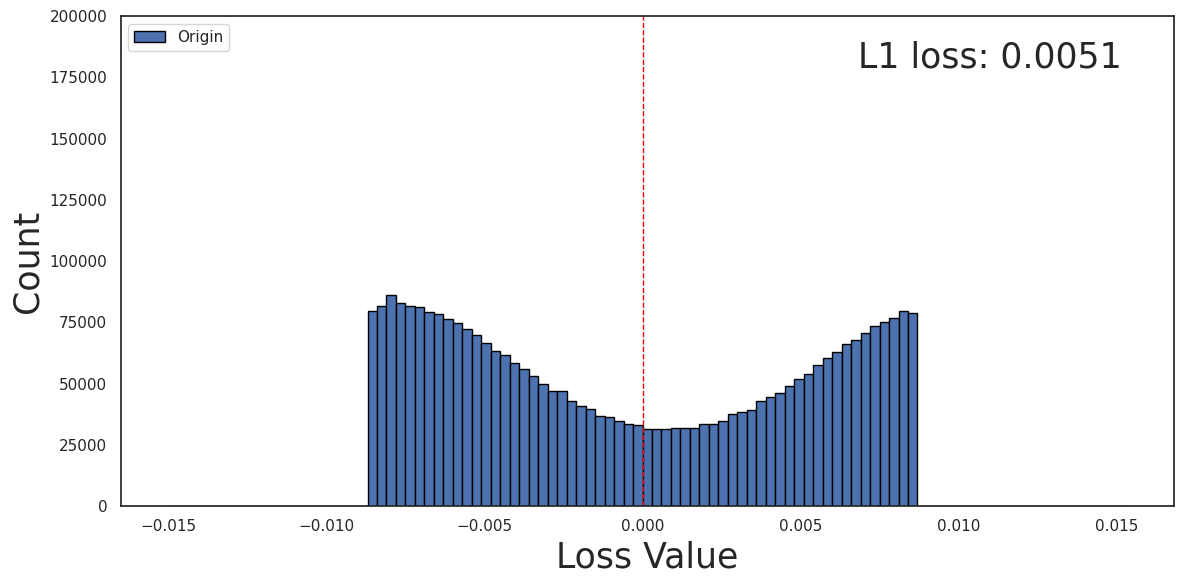

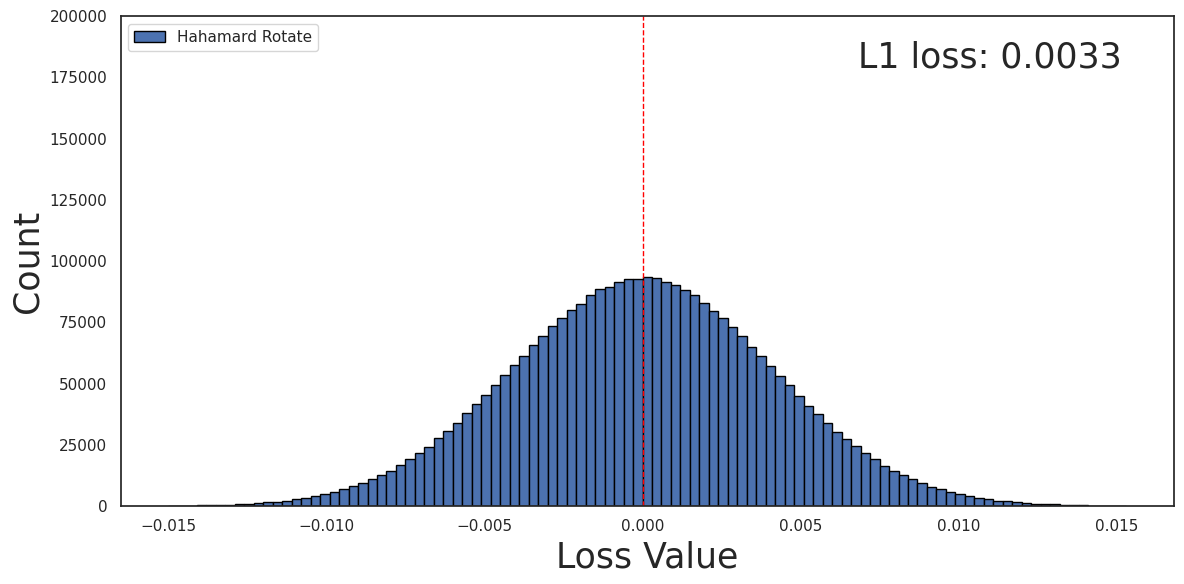

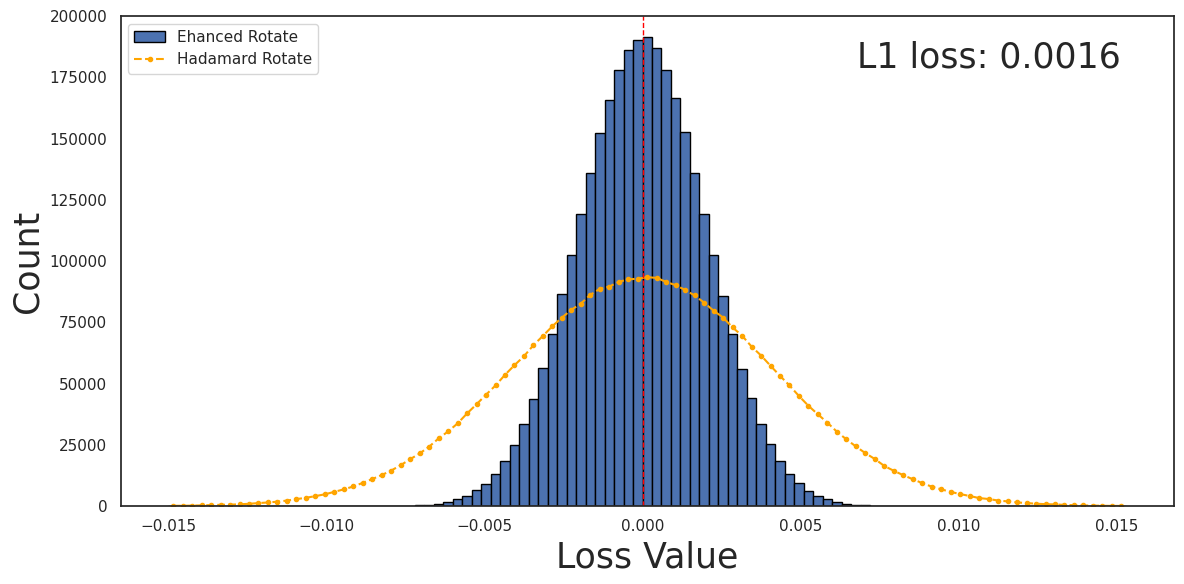

/tmp/ipykernel_1747926/1194666753.py:51: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


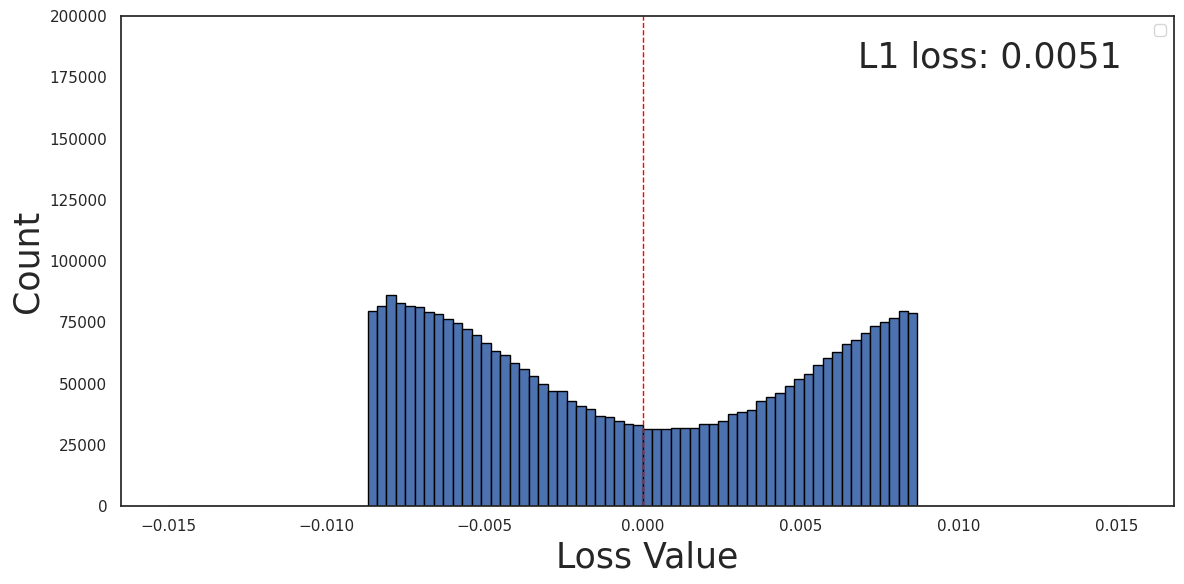

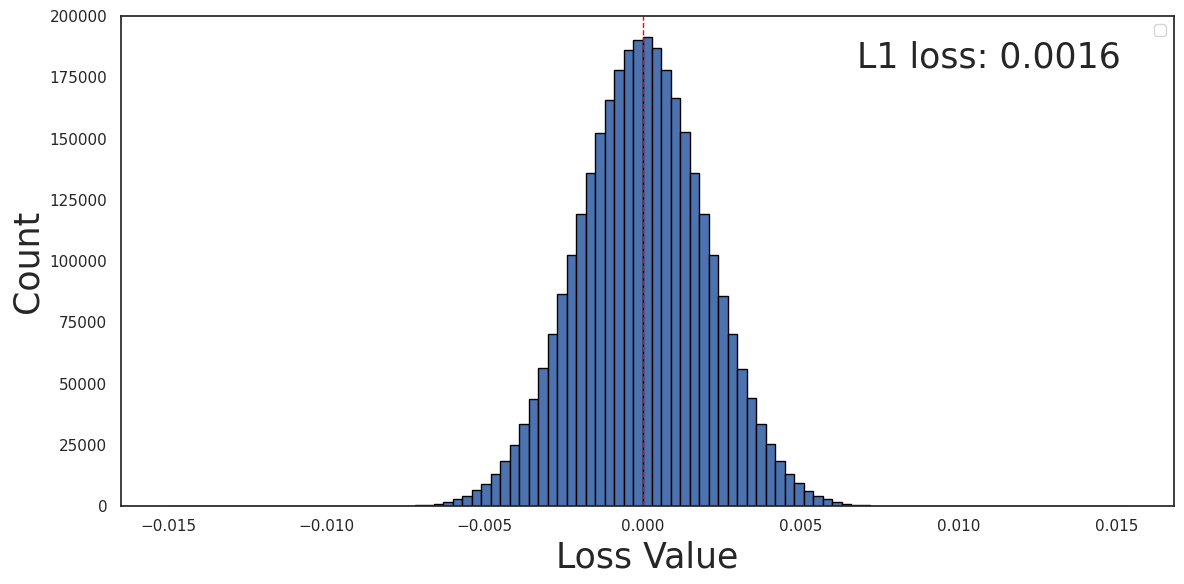

In [45]:
def plot_bar_fig(data1, data2, loss,path=""):
    # 将 data1 转换为 numpy 数组
    if isinstance(data1, torch.Tensor):
        if data1.requires_grad:
            data1 = data1.detach().cpu().numpy()
        else:
            data1 = data1.cpu().numpy()

    # 将 data2 转换为 numpy 数组
    if isinstance(data2, torch.Tensor):
        if data2.requires_grad:
            data2 = data2.detach().cpu().numpy()
        else:
            data2 = data2.cpu().numpy()

    # 计算 data1 的直方图
    # min_ = np.min(data1)
    # max_ = np.max(data1)
    min_ = -0.015
    max_ = 0.015
    data_range = max_ - min_
    bin_width = data_range / 100  # 设定每个区间的宽度
    bins = np.arange(min_, max_ + bin_width, bin_width)
    plt.figure(figsize=(12, 6))
    
    # 绘制 data1 的直方图
    counts1, bin_edges1, _ = plt.hist(data1.reshape(-1), bins=bins, edgecolor='black', label=path)

    # 计算 data2 的直方图，但不绘制
    counts2, bin_edges2 = np.histogram(data2.reshape(-1), bins=bins)

    # 获取柱子的中心位置
    bin_centers = (bin_edges1[:-1] + bin_edges1[1:]) / 2

    # 绘制 data2 的折线图，连接柱子的顶点
    if path == "Ehanced Rotate":
        plt.plot(bin_centers, counts2, color='orange', linestyle='--', marker='.', label='Hadamard Rotate')

    # 设置横纵坐标范围
    # plt.xlim(min_, max_)  # 根据 data1 的范围设置横坐标范围
    # plt.xlim(-0.015, 0.015)  # 限制横坐标范围
    plt.ylim(0, 200000)  # 限制横坐标范围
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1)

    # 添加文字注释
    plt.text(0.95, 0.95, f'L1 loss: {loss:.4f}',fontsize=25, horizontalalignment='right', verticalalignment='top', transform=plt.gca().transAxes)

    # 设置图例和标签
    plt.xlabel("Loss Value",fontsize=25)
    plt.ylabel("Count",fontsize=25)
    plt.legend()

    # 自动调整布局
    try:
        plt.tight_layout()
    except Exception as e:
        print(f"Warning: tight_layout failed with error: {e}")

    # 显示图表
    plt.show()


loss1 = data-dequantize(*quantize(data, 4))
plot_bar_fig(loss1.float(),torch.tensor(0),loss1.abs().mean(),"Origin")
## loss2 = data.float()@K.float()-dequantize(*quantize(data.float()@K.float(), 4))
# loss2 = data-dequantize(*quantize(data.float()@K.float(), 4))@K.T.float()
# plot_bar_fig(loss2.float(),torch.tensor(0),loss2.abs().mean(),"KLT Rotate")
# # loss3 = data.float()@R.float()-dequantize(*quantize(data.float()@R.float(), 4))
# loss3 = data-dequantize(*quantize(data.float()@R.float(), 4))@R.T.float()
# plot_bar_fig(loss3.float(),torch.tensor(0),loss3.abs().mean(),"Hahamard Rotate")
## loss4 = data.float()@R.float()@R.float()-dequantize(*quantize(data.float()@R.float()@R.float(), 4))
loss4 = data-dequantize(*quantize(data.float()@R.float()@R.float(), 4))@R.T.float()@R.T.float()
plot_bar_fig(loss4.float(),torch.tensor(0),loss4.abs().mean(),"Hahamard Rotate")
## loss5 = data.float()@K.float()@R.float()-dequantize(*quantize(data.float()@K.float()@R.float(), 4))
loss5 = data-dequantize(*quantize(data.float()@K.float()@R.float(), 4))@R.T.float()@K.T.float()
plot_bar_fig(loss5.float(),loss4,loss5.abs().mean(),"Ehanced Rotate")

plot_bar_fig(loss1,torch.tensor(0),loss1.abs().mean())
plot_bar_fig(loss5,loss4,loss5.abs().mean())

### GPU使用

In [ ]:
import torch

def occupy_gpu_memory(size_in_gb, gpu_id=0):
    while True:
        device = torch.device(f'cuda:{gpu_id}')  # 指定GPU
        size_in_bytes = int(size_in_gb * 1e9 / 4)  # 4字节表示一个float32
        dummy_tensor = torch.ones(size_in_bytes, dtype=torch.float32, device=device)
        dummy_tensor /= 0.1
        dummy_tensor *= 10
        # print(f"Successfully allocated {size_in_gb} GB of GPU memory on GPU {gpu_id}")
    return dummy_tensor

# 例如，占用10GB的显存在 GPU 1 上
tensor = occupy_gpu_memory(30, gpu_id=3)

In [22]:
import time
import torch
import pynvml

# 初始化 NVML
pynvml.nvmlInit()

def get_gpu_memory_info():
    device_count = pynvml.nvmlDeviceGetCount()  # 获取可用 GPU 的数量
    gpu_info = []
    for i in range(device_count):
        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
        mem_info = pynvml.nvmlDeviceGetMemoryInfo(handle)
        gpu_info.append({
            'index': i,
            'free': mem_info.free,
            'total': mem_info.total,
            'used': mem_info.used
        })
    return gpu_info

def occupy_memory(gpu_index, memory_to_occupy):
    # 使用指定的 GPU
    device = torch.device(f'cuda:{gpu_index}')
    try:
        # 计算需要的张量大小 (float32 需要 4 字节)
        tensor_size = int(memory_to_occupy/4)  # 单位：MB
        tensor = torch.randn(tensor_size, device=device)
        print(f"成功占用了 GPU {gpu_index} 的 {memory_to_occupy / (1024**3)} GB 显存")
        return tensor  # 返回张量以保持占用显存
    except Exception as e:
        print(f"显存占用失败: {e}")
        return None

def monitor_and_occupy_memory():
    while True:
        gpu_info = get_gpu_memory_info()
        for gpu in gpu_info:
            free_memory_gb = gpu['free'] / (1024 ** 3)  # 将空余显存转换为 GB
            if free_memory_gb > 50:  # 如果空余显存超过 50GB
                print(f"GPU {gpu['index']} 有 {free_memory_gb:.2f} GB 空余显存，准备占用...")
                return occupy_memory(gpu['index'], 20 * 1024 * 1024 * 1024)  # 占用 50GB
        print("没有找到空余显存超过 50GB 的显卡，继续监控...")
        time.sleep(1000)  # 每 10 秒检查一次

occ_tensor = monitor_and_occupy_memory()


GPU 3 有 79.32 GB 空余显存，准备占用...
成功占用了 GPU 3 的 20.0 GB 显存
